# TCNN Classifier

In [3]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import sys
import numpy as np
import random
from sklearn.metrics import accuracy_score

sys.path.append('../scripts')
import ml_helper
import ml_evaluation
import Tcnn as tcnn
import Baseline_classifiers as bc

In [4]:
data_path = '../data'

Code inspiered:

https://de.mathworks.com/help/deeplearning/ug/sequence-to-sequence-classification-using-1-d-convolutions.html

References:

- [1] Bai, Shaojie, J. Zico Kolter, and Vladlen Koltun. “An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling.” Preprint, submitted April 19, 2018. https://arxiv.org/abs/1803.01271.

- [2] Oord, Aaron van den, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. “WaveNet: A Generative Model for Raw Audio.” Preprint, submitted September 12, 2016. https://arxiv.org/abs/1609.03499.

- [3] Tompson, Jonathan, Ross Goroshin, Arjun Jain, Yann LeCun, and Christoph Bregler. “Efficient Object Localization Using Convolutional Networks.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 648–56. https://doi.org/10.1109/CVPR.2015.7298664.


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
SEED = 42
def set_seed(SEED=SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
set_seed()

### Data Preparation

In [7]:
# Data preparation
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[2]
#"Homo.Sapiens"  "Drosophila.Melanogaster"  "E.Coli"
min_length = None
max_length = 500
one_hot = True

SPEEDS_ADDED = False
BATCH_SIZE = 32

In [8]:
test_dataset = ml_helper.CodonDataset(organism, "test", min_length, max_length, add_speeds=SPEEDS_ADDED, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge test_dataset: {len(test_dataset)}")

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Länge test_dataset: 17489


### Load the model

In [9]:
class TemporalConvNet(nn.Module):
    def __init__(self, num_features: int, num_classes: int, num_filters: int, filter_size: int, 
                 dropout_factor: float, num_blocks: int, parallel_layer: bool) -> None:
        """
        This function initializes the TemporalConvNet model
        ------
        num_features: number of features in the input
        num_classes: number of classes to predict
        num_filters: number of filters in each convolutional layer
        filter_size: size of the convolutional filter
        dropout_factor: dropout factor
        num_blocks: number of blocks of dilated convolutions
        parallel_layer: whether to add the parallel layer
        """
        super(TemporalConvNet, self).__init__()
        self.num_blocks = num_blocks
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.dropout_factor = dropout_factor
        self.parallel_layer = parallel_layer
        if self.parallel_layer:
            self.optional_layer = nn.Conv1d(num_features, num_filters, kernel_size=1)

        self.layers = nn.ModuleList()
        # Input layer
        self.layers.append(nn.Conv1d(num_features, num_filters, kernel_size=1))
        self.layers.append(nn.BatchNorm1d(num_filters))
        
        # Dilated convolutional blocks
        for i in range(num_blocks):
            dilation = 2 ** i
            # this function defines the padding and therefore teh sequence length
            pad = (filter_size - 1) * dilation // 2 
            # TODO: fix for even filter size
            self.layers.append(nn.Conv1d(num_filters, num_filters, kernel_size=filter_size, dilation=dilation, padding=pad))
            self.layers.append(nn.BatchNorm1d(num_filters))
            # if last than not dropout
            if i != num_blocks - 1:
                self.layers.append(nn.Dropout(dropout_factor))

        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout_factor))

        self.layers.append(nn.Softmax(dim=1))

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        This function defines the forward pass of the model
        ------
        x: input tensor of shape (batch_size, num_features, sequence_length)
        ------
        returns: output tensor of shape (batch_size, num_classes, sequence_length)
        """
        x_init = x.permute(0, 2, 1)
        x = x_init.clone()
        for layer in self.layers:
            x = layer(x)
        # skipped all other connections and add it at the end
        if self.parallel_layer:
            x_optional = self.optional_layer(x_init)
            x = x + x_optional

        return x

In [10]:
tcn_model = ml_helper.load_model(f'tcn', organism)

Model loaded: 20240609020834_tcn_valid_acc_42.pt


### Evaluation of the model

In [11]:
def evaluate_model(model, device, test_loader: DataLoader) -> list:
    """
    This function evaluates the model on the test data
    ------
    model: model to evaluate
    test_loader: DataLoader with the test data
    ------
    returns: list with the predictions and labels
    """
    model.eval()  # Set the model to evaluation mode
    accuracies = []

    with torch.no_grad():
        for input_data, labels in test_loader:

            input_data = input_data.to(device)
            labels = labels.to(device)

            labels = labels.view(-1)

            # Forward pass
            outputs = model(input_data)
            
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.view(-1)

            # Compute custom metrics
            accuracy = accuracy_score(predicted.cpu(), labels.cpu())
            accuracies.append(accuracy)

    # Compute average accuracy
    
    return predicted, labels, accuracies

In [12]:
predicted, labels, accuracies = evaluate_model(tcn_model, device, test_loader)

#### Get codon names and associated amino acids

In [13]:
predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

predicted, labels = ml_evaluation.filter_padding(predicted, labels, filter_value=64)

predicted_codon_names =  ml_evaluation.codon_to_name(predicted)
labels_codon_names =  ml_evaluation.codon_to_name(labels)

predicted_aa =  ml_evaluation.translate_codons(predicted_codon_names)
labels_aa =  ml_evaluation.translate_codons(labels_codon_names)

ml_evaluation.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
ml_evaluation.print_unique_elements(predicted_aa, labels_aa)

predicted different classes:  54 out of: 61
predicted following classes:  {'GAA', 'CAT', 'CCC', 'TTG', 'TCT', 'GTC', 'TTT', 'ATT', 'ACT', 'AGC', 'GGC', 'AGG', 'GGT', 'AAT', 'GCA', 'GGA', 'GTG', 'AGA', 'AAC', 'CTG', 'GGG', 'AAG', 'TAC', 'ATG', 'CCT', 'TGG', 'CTC', 'CGC', 'ATA', 'GTT', 'ACA', 'ACC', 'GCC', 'TGC', 'CAG', 'GAG', 'GCT', 'CAC', 'ATC', 'TGT', 'TTC', 'CTT', 'CAA', 'CGG', 'TCC', 'GAC', 'AAA', 'CGT', 'CCA', 'TAT', 'AGT', 'TCA', 'CGA', 'GAT'}
predicted different amino acids:  20 out of: 20


#### Accuracies

In [14]:
# Calculate Accuracy of amino 
avg_accuracy = np.mean(accuracies)
accuracy_aa = accuracy_score(labels_aa, predicted_aa)

print('-' * 100)
print(f'For Organism {organism} Average accuracy: {avg_accuracy}')
print(f'Accuracy of amino acids: {accuracy_aa}')
print('-' * 100)

----------------------------------------------------------------------------------------------------
For Organism Homo.Sapiens Average accuracy: 0.4171435759620333
Accuracy of amino acids: 1.0
----------------------------------------------------------------------------------------------------


# Test Shuffeld Data

In [15]:
test_shuffled_dataset = ml_helper.CodonDataset(organism, "test_shuffled", min_length, max_length, add_speeds=SPEEDS_ADDED, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge test_shuffled_dataset: {len(test_shuffled_dataset)}")

test_shuffled_loader = DataLoader(test_shuffled_dataset, batch_size=len(test_shuffled_dataset), shuffle=False)

Länge test_shuffled_dataset: 17489


In [16]:
predicted_shuffled, labels_shuffled, accuracies_shuffled = evaluate_model(tcn_model, device, test_shuffled_loader)

In [17]:
# Calculate Accuracy of amino 
avg_accuracy_shuffled = np.mean(accuracies_shuffled)
#accuracy_aa = accuracy_score(labels_aa, predicted_aa)

print('-' * 100)
print(f'For Organism {organism} Average shuffeld accuracy: {avg_accuracy_shuffled}')
#print(f'Accuracy shuffeld of amino acids: {accuracy_aa}')
print('-' * 100)

----------------------------------------------------------------------------------------------------
For Organism Homo.Sapiens Average shuffeld accuracy: 0.3131178455028875
----------------------------------------------------------------------------------------------------


## Plots

### Codon Accuracy

$$C\_Acc = \frac{T\_c}{G\_c} $$

- $T\_c$: Anzahl des richtig klassifizierten ausgewählten Codons über alle Testsequenzen eines betrachteten Organismus
- $G\_c$: Gesamtanzahl des ausgewählten Codons über alle Testsequenzen eines betrachteten Organismus

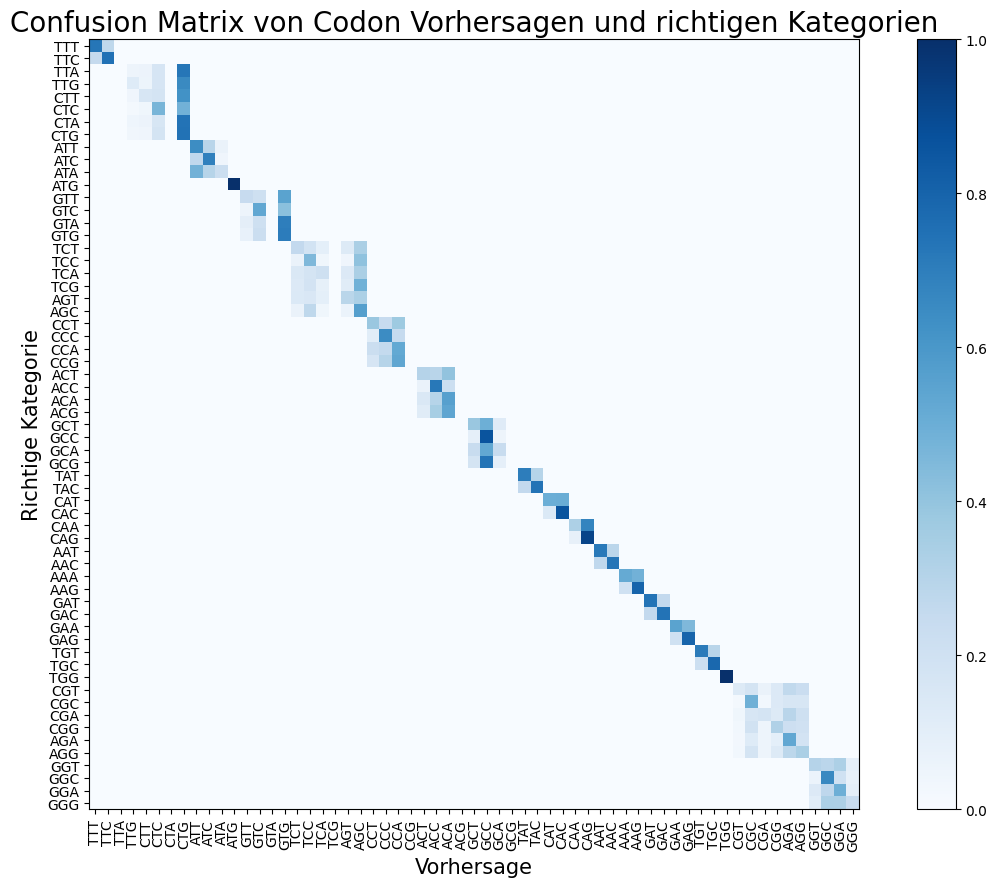

In [18]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien'

codons = [c for c in ml_helper.codons if c != '___']

plt = ml_evaluation.plot_confusion_matrix(labels, predicted, ml_helper.codons_sorted, title, sort_codons=True)
plt.show()

### Aminosäuren Accuracy

$$A\_Acc = \frac{T\_a}{G\_a} $$

- $T\_a$: Anzahl der richtig klassifizierten ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus
- $G\_a$: Gesamtanzahl der ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus

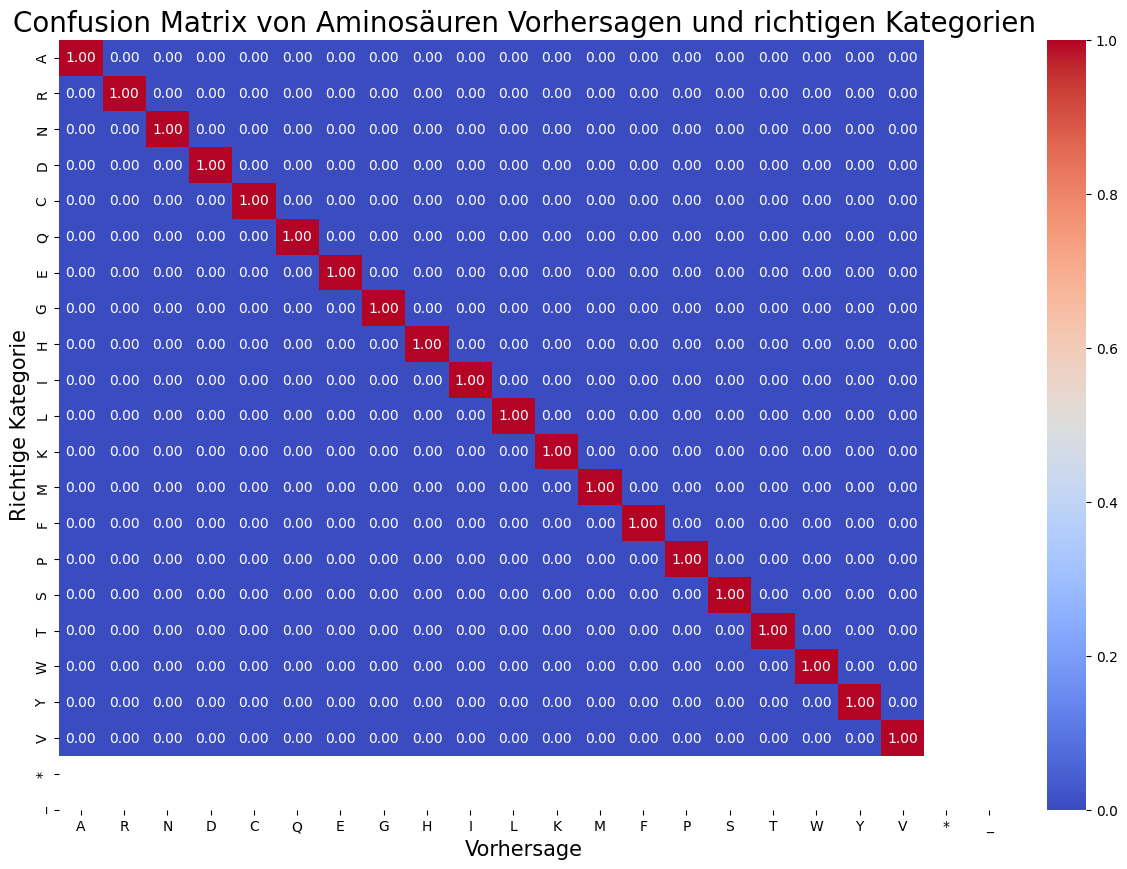

In [19]:
# Calculate confusion matrix for amino acids

plt = ml_evaluation.plot_confusion_matrix_sns(labels_aa, predicted_aa, ml_helper.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien')
plt.show()

{'ATG': 137692, 'GAA': 120323, 'CGG': 22800, 'CAC': 80095, 'CAG': 213624, 'CCG': 0, 'CTG': 177222, 'GCC': 146884, 'CAA': 29379, 'GGC': 85867, 'TCA': 19308, 'GCT': 47057, 'GGG': 23715, 'ACT': 27742, 'CCC': 81104, 'TAC': 63553, 'CCT': 47839, 'TCC': 51449, 'TCT': 28325, 'CTC': 54461, 'CGC': 28668, 'TGC': 54178, 'AGC': 73309, 'AAG': 166814, 'AGG': 26753, 'AGT': 26102, 'GAG': 209491, 'TTT': 78692, 'GAC': 118720, 'AAA': 90693, 'ATA': 11324, 'AGA': 45122, 'ATT': 67621, 'CCA': 64207, 'CTT': 14521, 'AAC': 86474, 'GCA': 26074, 'GAT': 115365, 'TTA': 0, 'AAT': 83979, 'TTG': 10844, 'TTC': 83554, 'ATC': 83450, 'GTG': 119387, 'ACA': 59714, 'GGA': 54275, 'CGA': 7187, 'CAT': 36766, 'GTC': 46069, 'ACC': 82916, 'TGG': 74383, 'GTT': 18204, 'GTA': 0, 'TGT': 45921, 'CTA': 0, 'ACG': 0, 'TAT': 53623, 'GCG': 0, 'GGT': 20963, 'CGT': 3910, 'TCG': 0}


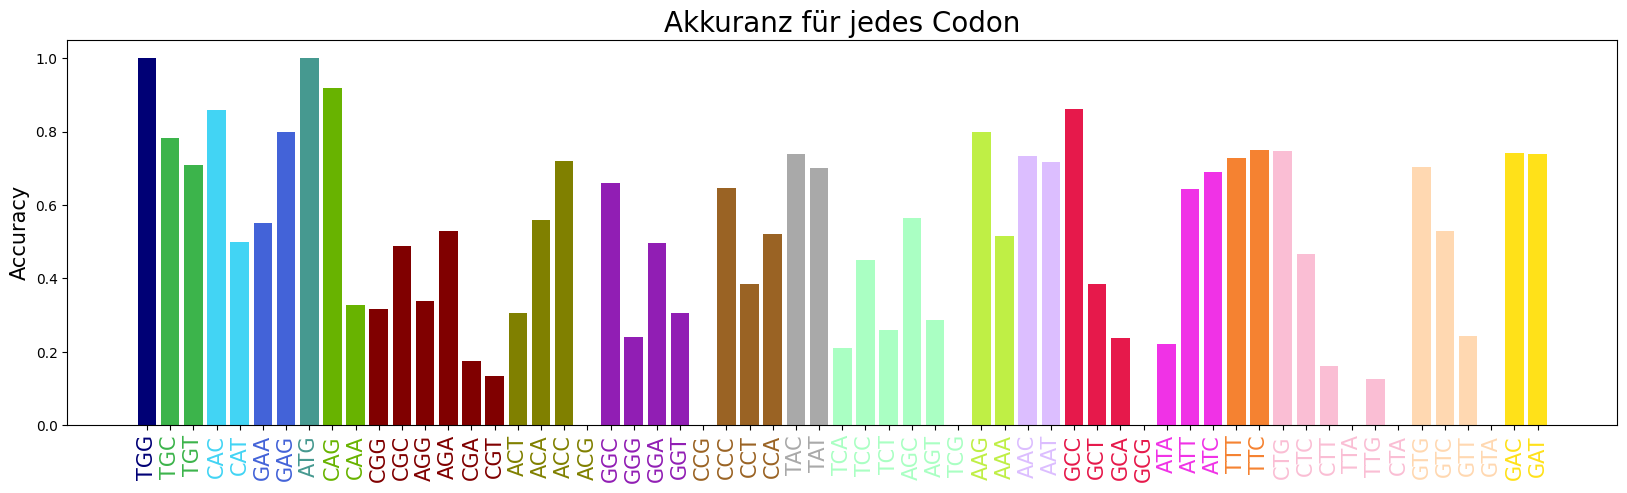

In [20]:
plt = ml_evaluation.plot_codon_acc(labels, predicted, 'Akkuranz für jedes Codon')

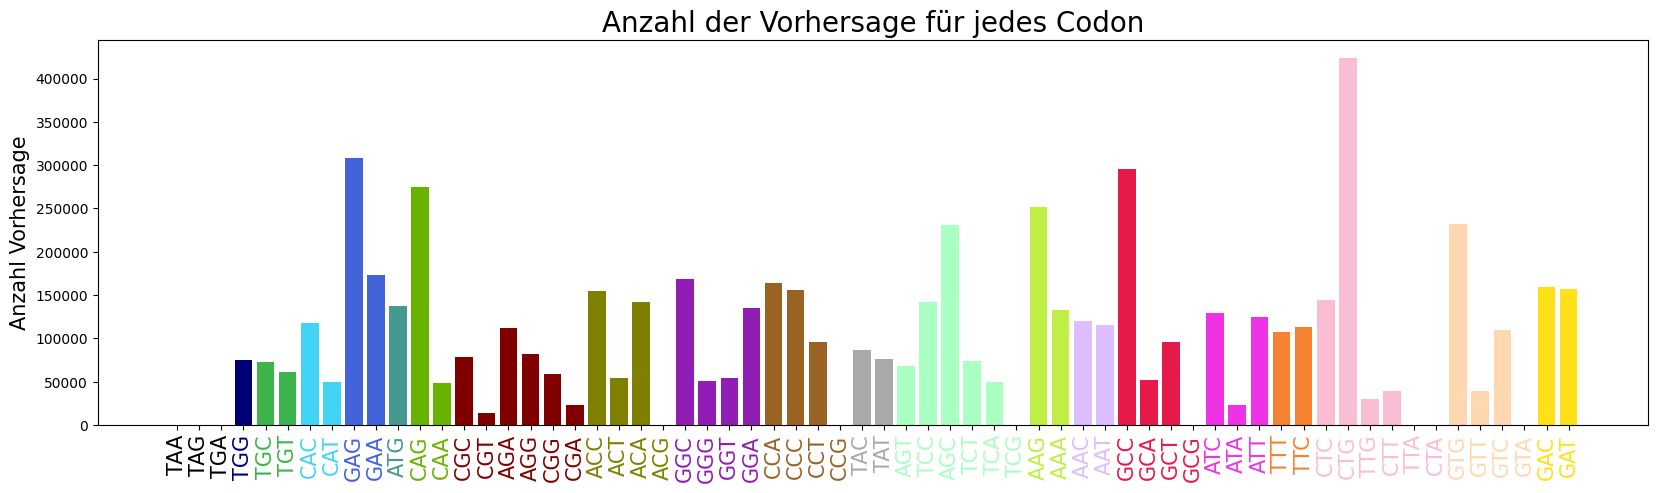

In [21]:
codon_counted_predicted = ml_evaluation.codon_count(predicted)

plt = ml_evaluation.plot_codon_count(codon_counted_predicted, 'Anzahl der Vorhersage für jedes Codon')

### Durchschnittliche Codon Accuracy

$$Avg\_CACC = \frac{\sum_{sc \in SC} c\_acc\{sc\}}{|SC|} $$

- $c\_acc$: Codon Accuracy
- $SC$: Synonyme Codons für die ausgewählte Aminosäure über alle Testsequenzen eines betrachteten Organismus

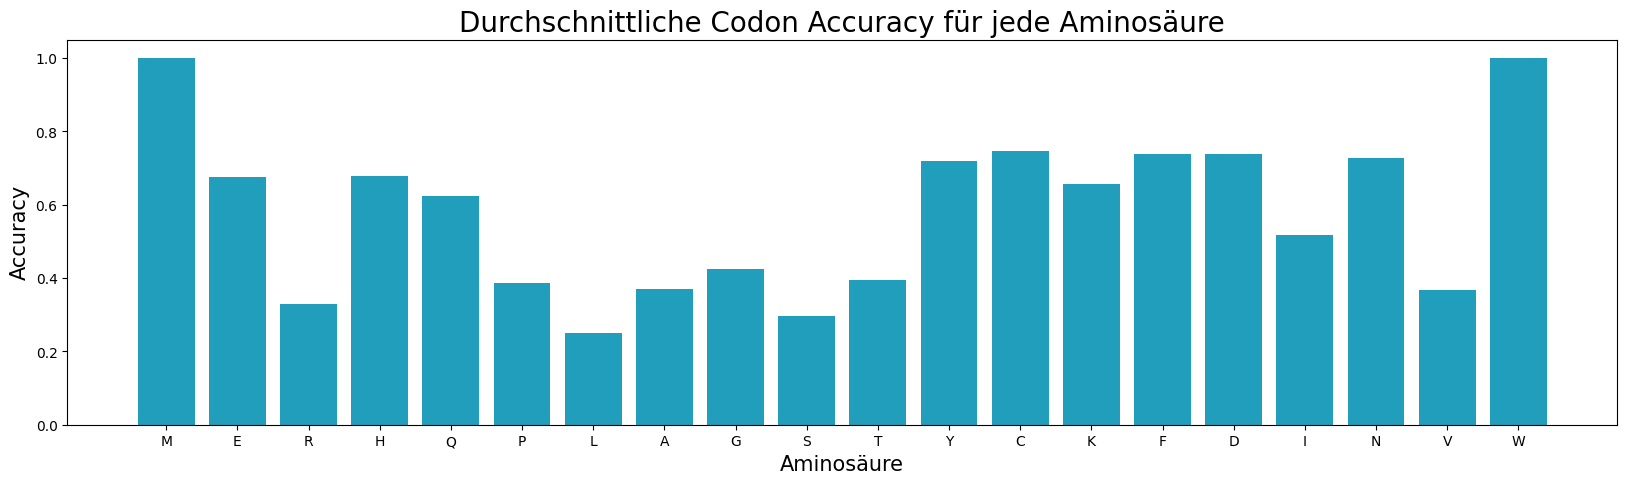

In [22]:

plt = ml_evaluation.plot_avg_aa_acc(labels, predicted)
plt.show()

In [23]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Datensatz geladen für E.Coli
Model loaded: 20240609010637_tcn_valid_acc_29.pt


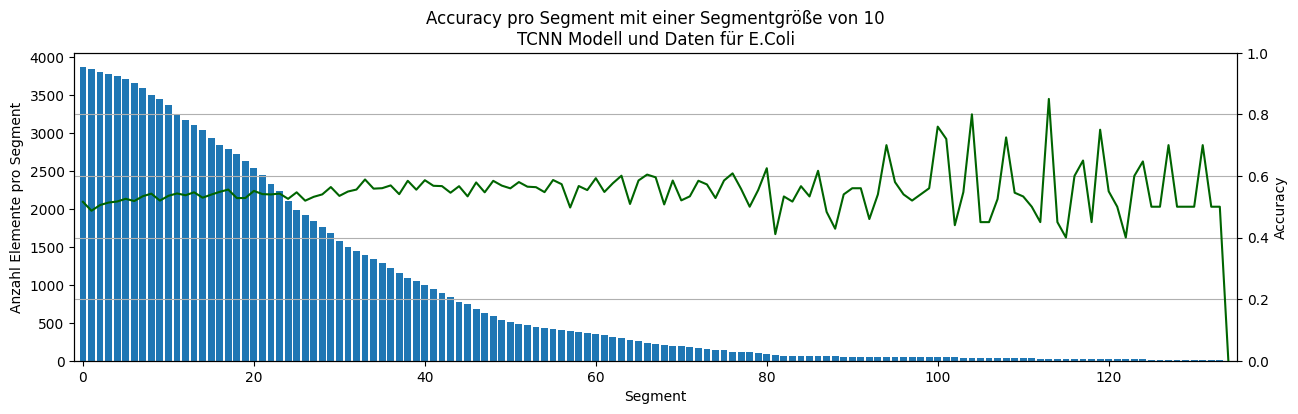

Datensatz geladen für Drosophila.Melanogaster
Model loaded: tcn_Drosophila.Melanogaster_model_20240512183059.pt


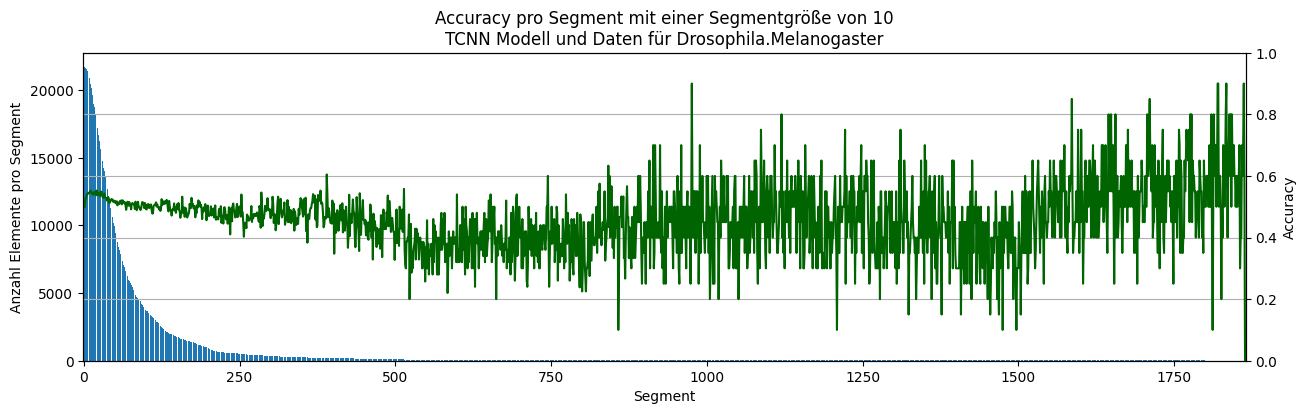

Datensatz geladen für Homo.Sapiens
Model loaded: 20240609020834_tcn_valid_acc_42.pt


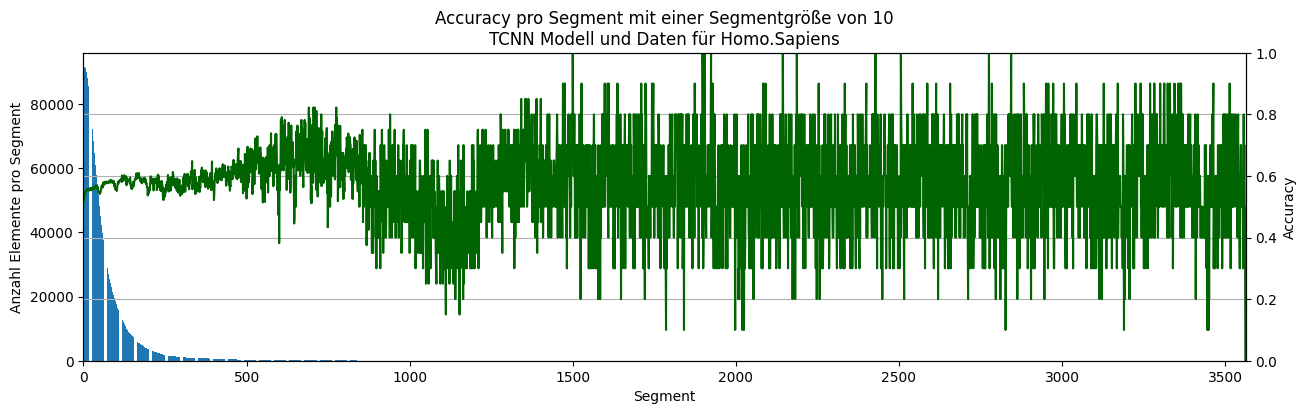

In [38]:
pad_int = ml_helper.codons.index('___')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for (org, segment_size) in [("E.Coli", 10), ("Drosophila.Melanogaster", 10), ("Homo.Sapiens", 10)]:
    test_dataset = ml_helper.CodonDataset(organism=org, split="test", padding_pos=None, data_path='../data/', one_hot_aa=False)
    test_loader = DataLoader(test_dataset, batch_size=1)
    print(f"Datensatz geladen für {org}")

    # test all models and save the best one for further evaluation
    tcnn_Model = ml_helper.load_model("tcn", org, device=device, path_model_dir="../ml_models")

    #classifier = rnn.RNN_Classifier(rnnModel)
    classifier = tcnn.Tcn_Classifier(tcnn_Model)
    preds = classifier.predict_codons(test_loader)

    predictions = []
    for pred in preds:
        pred_new = [int(p) if p != '___' and p != '' else int(pad_int) for p in pred]
        predictions.append(pred_new)
    

    labels = []
    for seq, lab in test_dataset:
        # lab = seq_lab[1]
        #print(lab)s
        #lab = [str(mlh.integer_to_codons[c.item()]) for c in lab]
        lab = [int(c.item()) for c in lab]
        labels.append(lab)

    for i, (lab, pred) in enumerate(zip(labels, predictions)):
        if len(lab) != len(pred):
            print(f"Mismatch at index {i}: labels length {len(lab)}, predictions length {len(pred)}")
    
    # labels = test_dataset[:][1]
    seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels, predictions, segment_size=segment_size)

    #seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels, predictions, segment_size=segment_size, cut_off=0.25)
    ml_evaluation.plot_accuracies_per_segment(seg_acc, seg_el, f"Accuracy pro Segment mit einer Segmentgröße von {segment_size}\nTCNN Modell und Daten für {org}")

Datensatz geladen für E.Coli
Model loaded: 20240609010637_tcn_valid_acc_29.pt


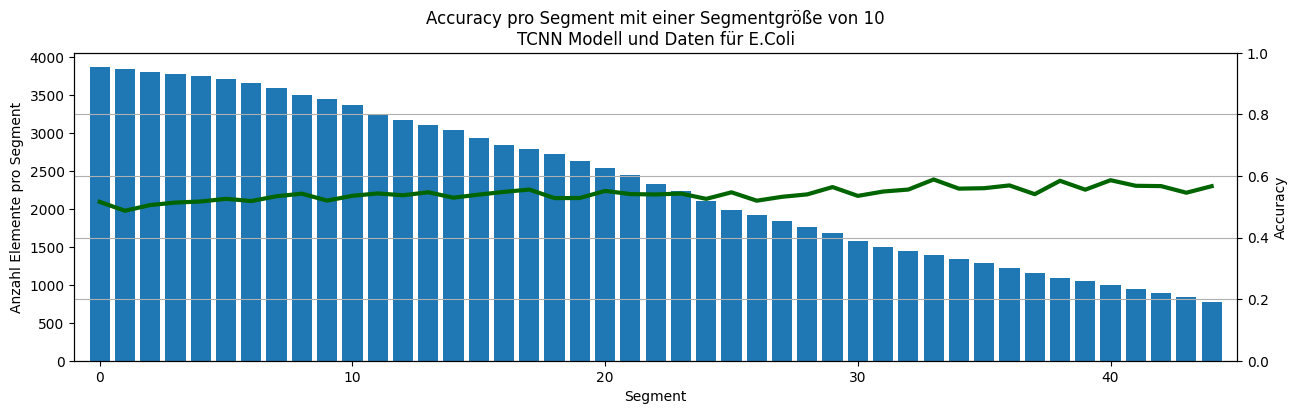

Datensatz geladen für Drosophila.Melanogaster
Model loaded: tcn_Drosophila.Melanogaster_model_20240512183059.pt


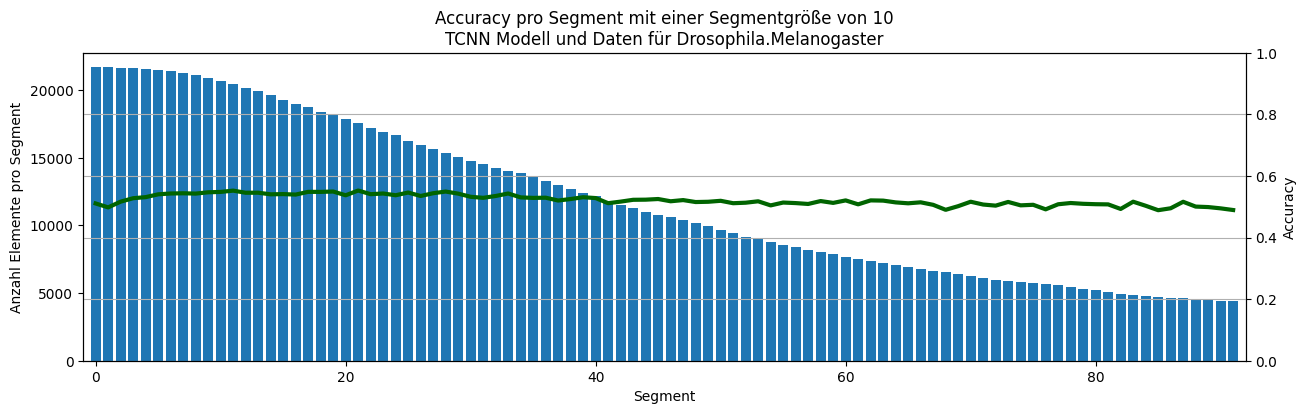

Datensatz geladen für Homo.Sapiens
Model loaded: 20240609020834_tcn_valid_acc_42.pt


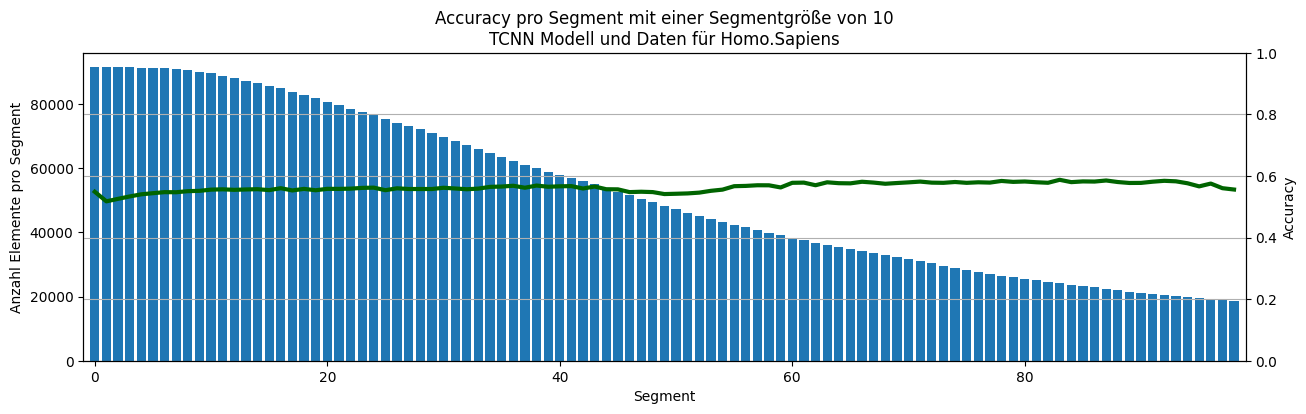

In [39]:
pad_int = ml_helper.codons.index('___')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for (org, segment_size) in [("E.Coli", 10), ("Drosophila.Melanogaster", 10), ("Homo.Sapiens", 10)]:
    test_dataset = ml_helper.CodonDataset(organism=org, split="test", padding_pos=None, data_path='../data/', one_hot_aa=False)
    test_loader = DataLoader(test_dataset, batch_size=1)
    print(f"Datensatz geladen für {org}")

    # test all models and save the best one for further evaluation
    tcnn_Model = ml_helper.load_model("tcn", org, device=device, path_model_dir="../ml_models")

    #classifier = rnn.RNN_Classifier(rnnModel)
    classifier = tcnn.Tcn_Classifier(tcnn_Model)
    preds = classifier.predict_codons(test_loader)

    predictions = []
    for pred in preds:
        pred_new = [int(p) if p != '___' and p != '' else int(pad_int) for p in pred]
        predictions.append(pred_new)
    

    labels = []
    for seq, lab in test_dataset:
        # lab = seq_lab[1]
        #print(lab)s
        #lab = [str(mlh.integer_to_codons[c.item()]) for c in lab]
        lab = [int(c.item()) for c in lab]
        labels.append(lab)

    for i, (lab, pred) in enumerate(zip(labels, predictions)):
        if len(lab) != len(pred):
            print(f"Mismatch at index {i}: labels length {len(lab)}, predictions length {len(pred)}")
    
    # labels = test_dataset[:][1]
    seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels, predictions, segment_size=segment_size, cut_data_at=0.2)

    #seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels, predictions, segment_size=segment_size, cut_off=0.25)
    ml_evaluation.plot_accuracies_per_segment(seg_acc, seg_el, f"Accuracy pro Segment mit einer Segmentgröße von {segment_size}\nTCNN Modell und Daten für {org}")